In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from captum.attr import DeepLift
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter

# savedfile = '../../Data/model_epoch_5.pth'
savedfile = '../../Data/trained_10ep.pth'
test_image_range = range(30,39)


LOAD MODEL

In [2]:
#Data preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')  # Prints 'cuda' if GPU is available, else 'cpu'

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5
image_size = (480, 960)  # Image size
color_channel = 1 # only grayscale, so 1 channel is enough

# Define the transformations (resize, normalize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to 960x480 pixels
    transforms.Grayscale(num_output_channels=color_channel),  # Convert to grayscale (1 channel)
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize((0.5), (0.5))  # Normalize the image between -1 and 1
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='../../Data/Training Image Dataset', transform=transform)
# test_dataset = datasets.ImageFolder(root='../../Data/Test Image Dataset 1', transform=transform)
test_dataset = datasets.ImageFolder(root='../../Data/Test Image Dataset 2 (Mixed singers)', transform=transform)

# DataLoader (to handle batch processing)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Using device: cuda


In [3]:
#Copied model structure from original file - NO MODIFICATION
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # shap expects CNN  to have self.conv_layers and self.fc_layers
        # Define the convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=color_channel, out_channels=16, kernel_size=3, stride=1, padding=1, device=device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, device=device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the size of the flattened output after conv + pooling
        conv_output_size = self._get_conv_output_size(image_size)

        # Define the fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 128),  # First fully connected layer
            nn.ReLU(),
            #nn.Dropout(),  # Add dropout for regularization
            nn.Linear(128, len(train_dataset.classes))  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = x.reshape(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)  # Pass through fully connected layers
        return x

    def _get_conv_output_size(self, img_size):
        """Helper function to calculate the size of the tensor after conv + pool."""
        with torch.no_grad():
            dummy_input = torch.ones(1, color_channel, *img_size).to(device)  # Dummy input
            x = self.conv_layers(dummy_input)  # Pass through conv layers
            return x.numel()  # Return the flattened size

In [4]:
model = torch.load(savedfile)
model.eval()

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=921600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

GradCAM

In [5]:
#GradCAM
def generate_gradcam(model, cam_extractor, image):
    """
    Generates a Grad-CAM heatmap for the given image and class index.
    """
    # Move the image to the device and add a batch dimension
    input_tensor = image.unsqueeze(0).to(device)

    # Enable gradients on the input tensor
    input_tensor.requires_grad_(True)

    # Forward pass through the model
    output = model(input_tensor)
    
    # Get the predicted class if not provided
    # if class_idx is None:
    class_idx = torch.argmax(output, dim=1).item()
    confidence_score = torch.softmax(output, dim=1)[0, class_idx].item()
    # Generate Grad-CAM heatmap
    activation_map = cam_extractor(class_idx, output)

    return activation_map, class_idx, confidence_score

def show_gradcam(image, label, activation_map, pred_class, class_name, confidence_score):
    # Convert grayscale tensor to a PIL image for visualization
    pil_img = to_pil_image(image.squeeze(0))
    
    # Extract the activation map (it’s a list)
    if isinstance(activation_map, list):
        activation_map = activation_map[0]

    # Resize the activation map to match the input image dimensions
    heatmap = torch.nn.functional.interpolate(
        activation_map.unsqueeze(0), size=image.shape[-2:], mode="bilinear", align_corners=False
    ).squeeze(0).squeeze(0).cpu().numpy()

    # Plot original image and Grad-CAM overlay
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original: {class_name[label]}\nPredicted: {class_name[pred_class]} ({confidence_score:.2f})", loc='left')
    plt.imshow(pil_img, cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(pil_img, cmap="gray", alpha=0.3)
    plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay heatmap with some transparency

    plt.show()


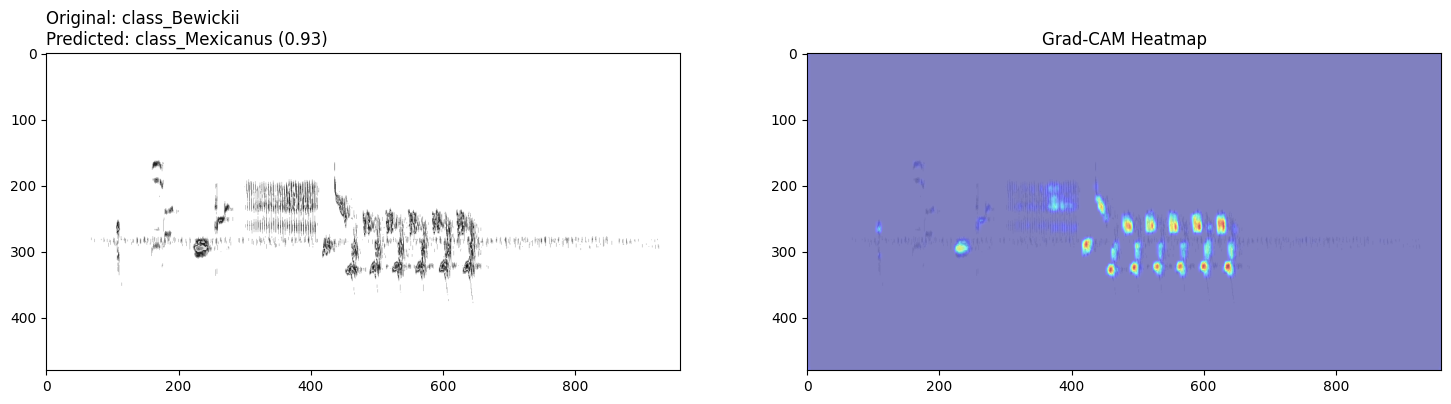

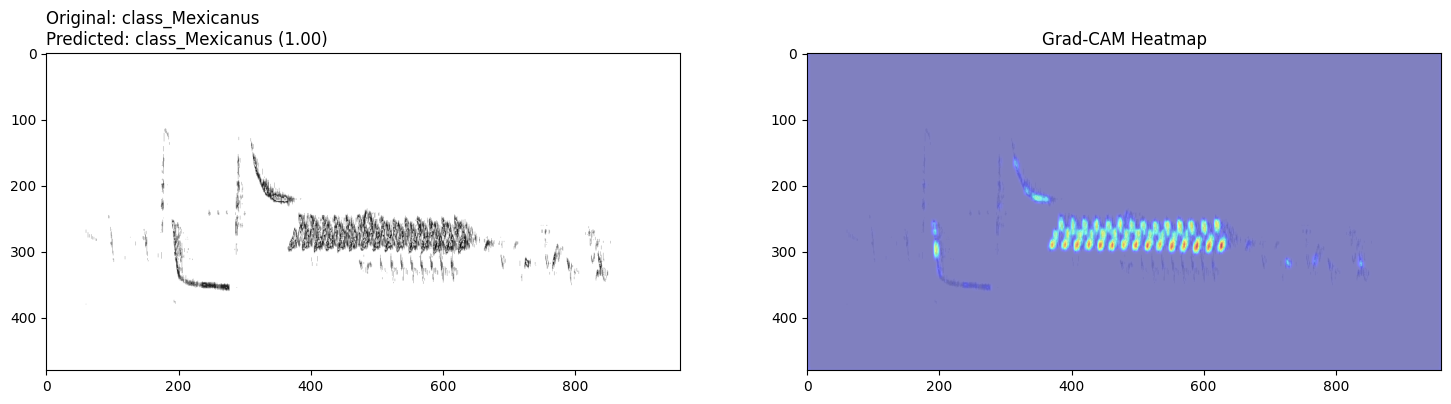

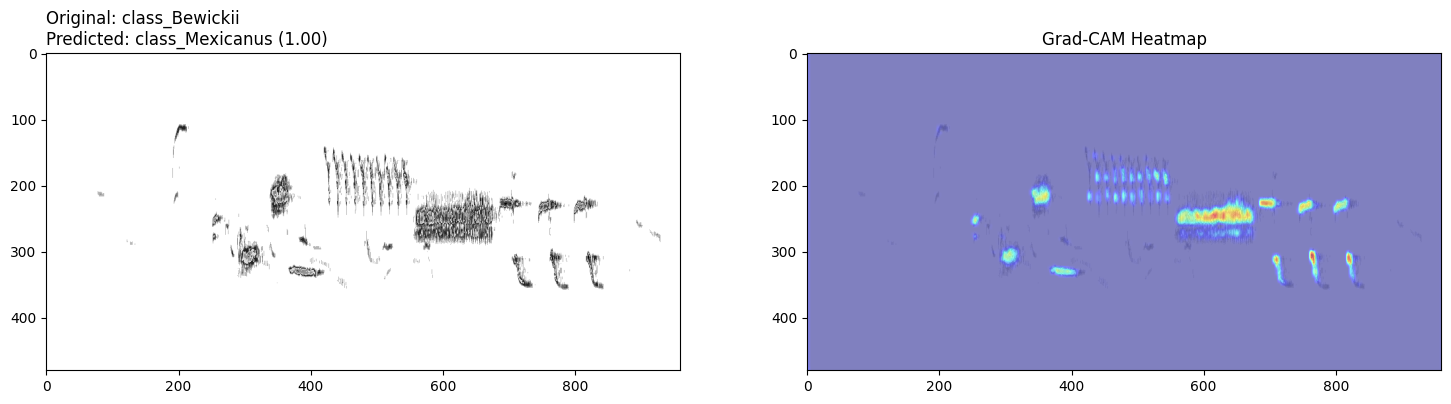

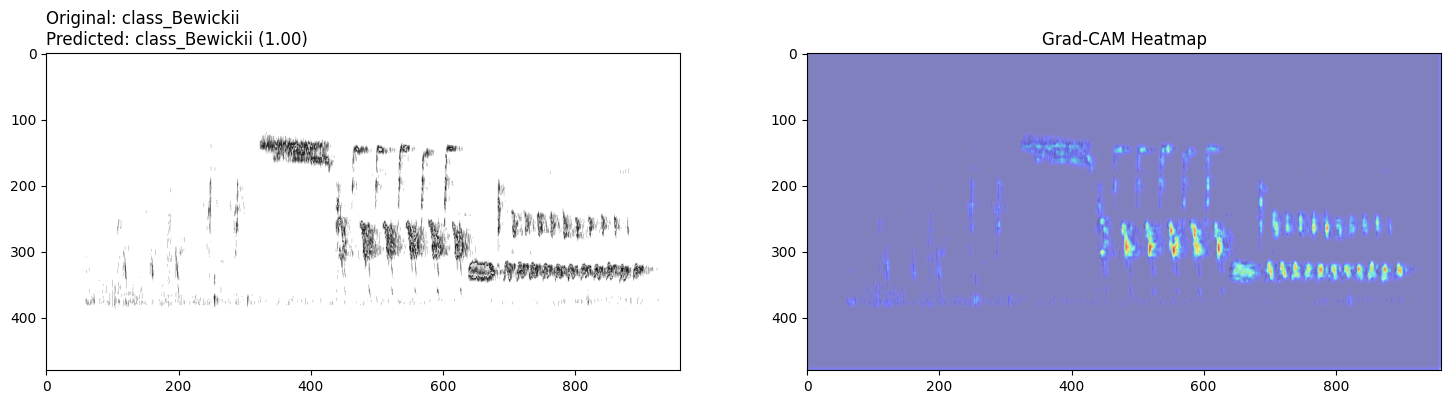

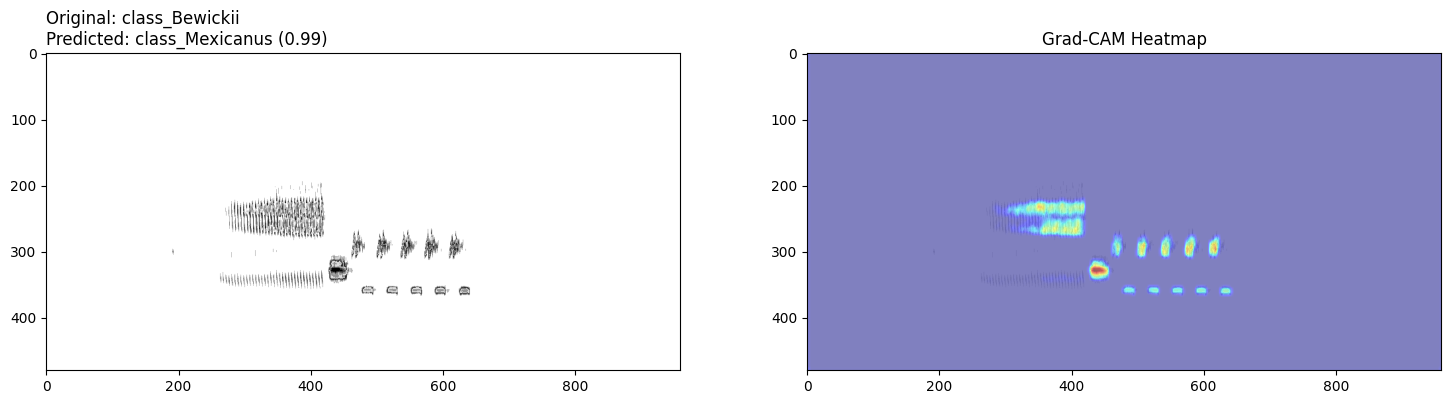

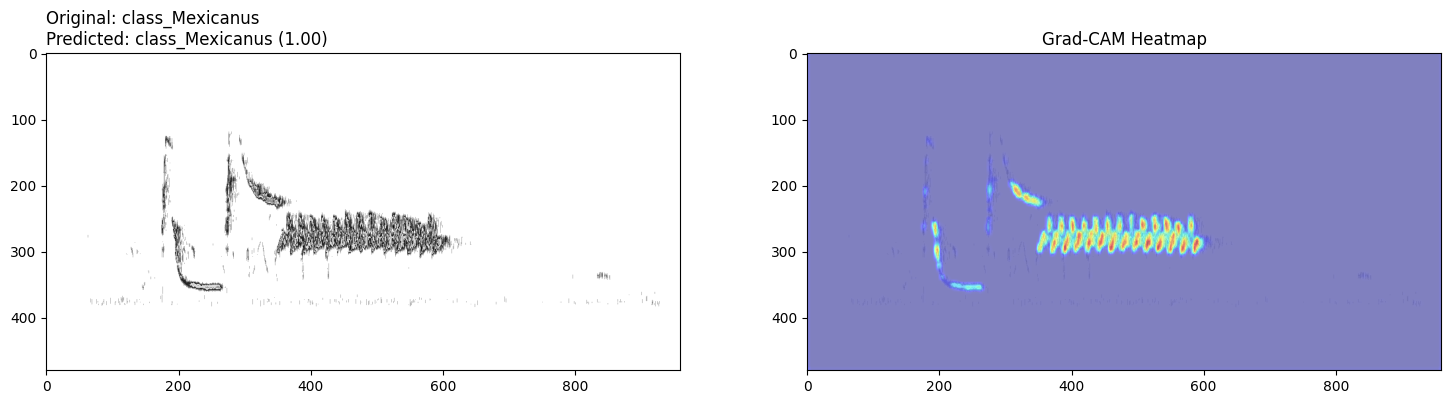

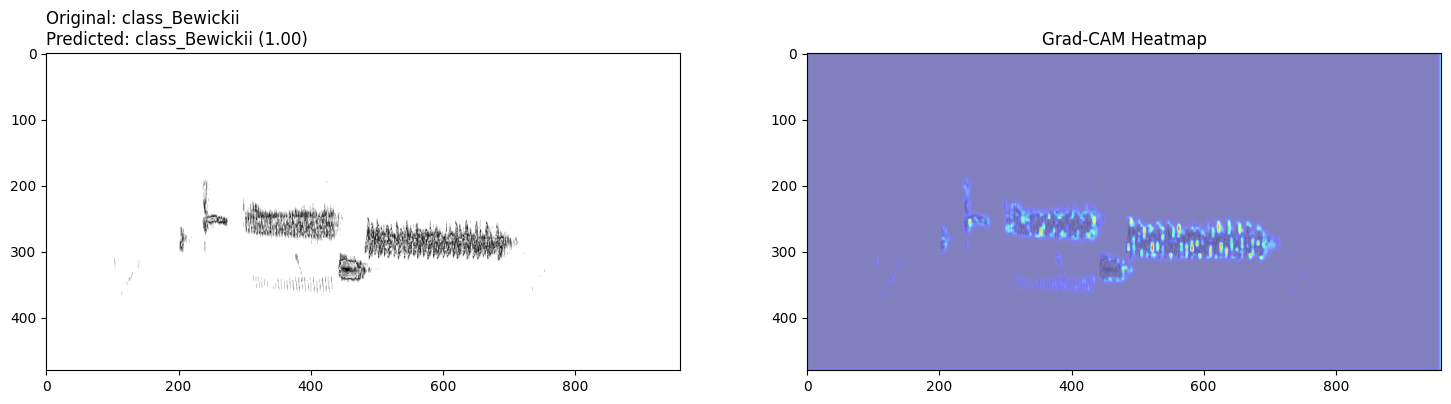

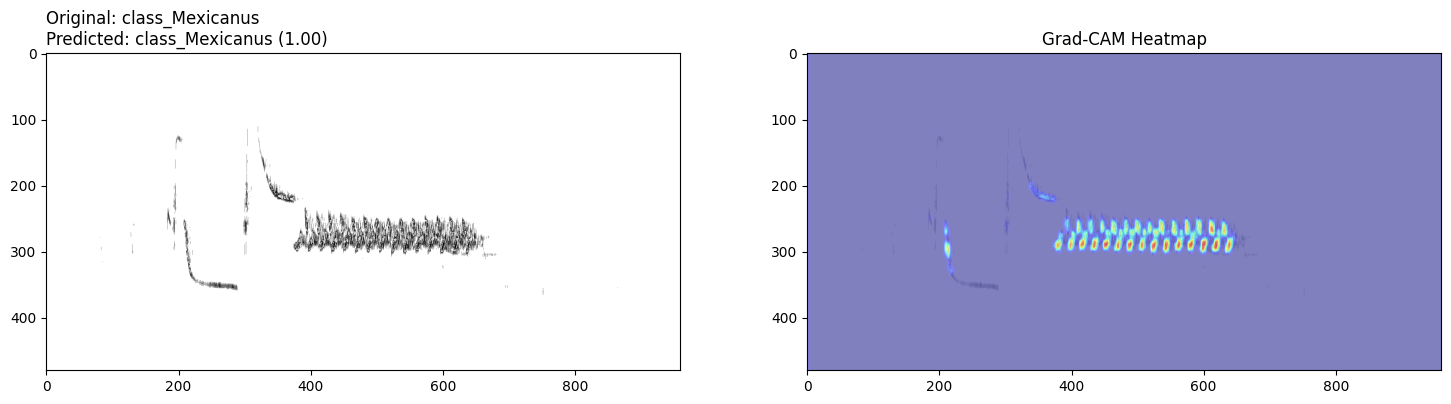

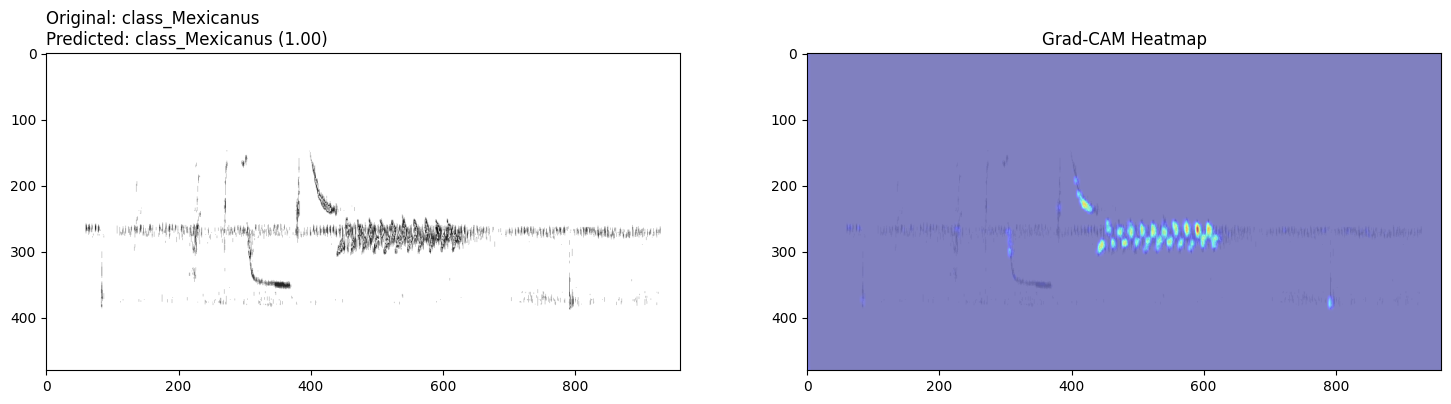

In [6]:
sample_image, sample_label = next(iter(test_loader))
# Define class names for display (assuming binary class labels)
class_name = train_dataset.classes
model = model.to(device)
for i in test_image_range:
    image = sample_image[i] 
    label = sample_label[i]

    cam_extractor = GradCAM(model, target_layer=model.conv_layers[5])
    # Generate Grad-CAM heatmap
    activation_map, pred_class, conf_score = generate_gradcam(model, cam_extractor, image)
    
    # Show the Grad-CAM
    show_gradcam(image, label, activation_map, pred_class, class_name, conf_score)



LRP with DeepLIFT from Captum

In [7]:
#LRP visualization
def visualize_lrp(image, attributions, label, class_idx, confidence_score):
    # Convert grayscale tensor to a PIL image for visualization
    pil_img = to_pil_image(image.squeeze(0).cpu())
    # Normalize attributions for visualization
    attributions = attributions.squeeze(0).squeeze(0).detach().cpu().numpy()
    att_min = attributions.min()
    att_max = attributions.max()
    attributions = (attributions - att_min) / (att_max - att_min)  # Normalize to [0, 1]
    smoothed_attributions = gaussian_filter(attributions, sigma=2)
    # Plot original image and LRP attributions
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original: {class_name[label]}\nPredicted: {class_name[class_idx]} ({confidence_score:.2f})", loc='left')
    plt.imshow(pil_img, cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title("LRP Attributions")
    plt.imshow(pil_img, cmap="gray", )
    plt.imshow(smoothed_attributions, cmap="jet", alpha=0.5)  # Overlay heatmap with some transparency
    plt.show()


c:\Users\td64s\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\td64s\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


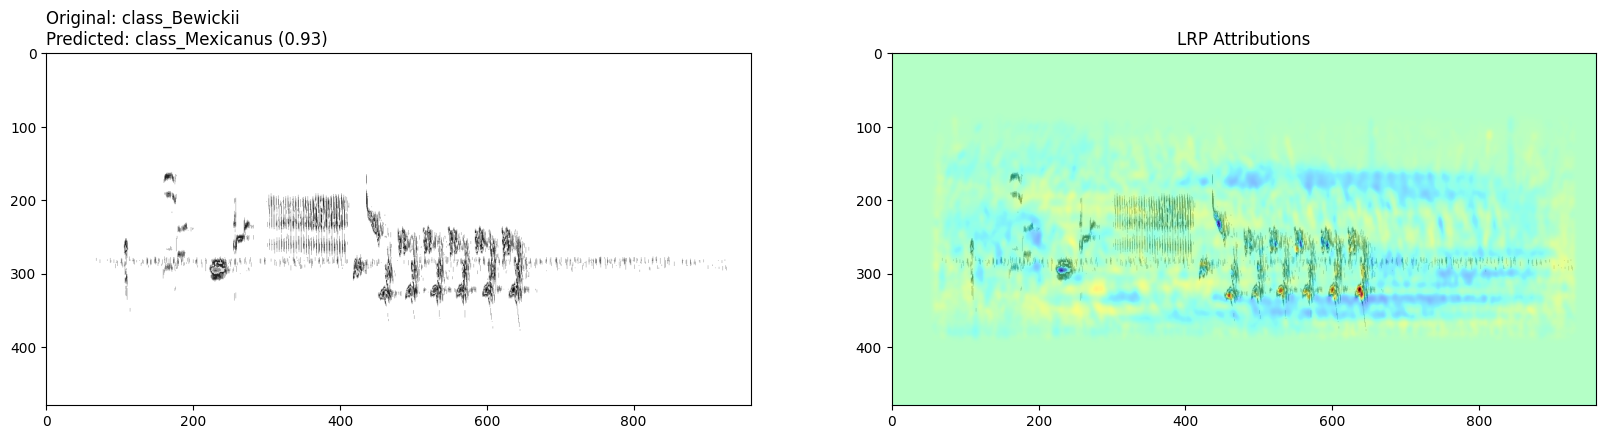

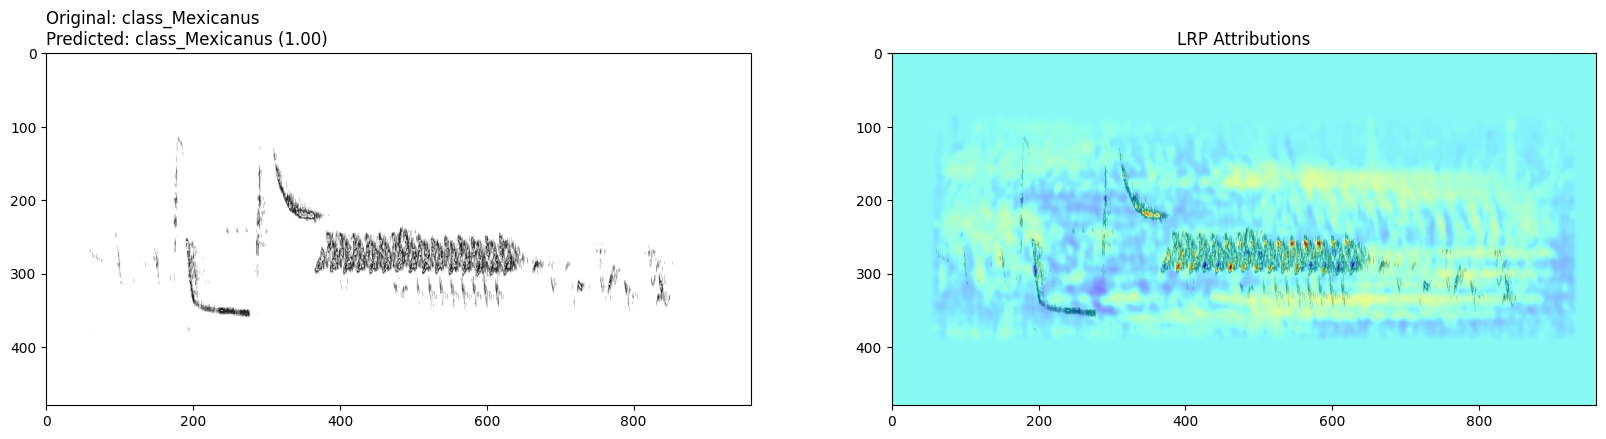

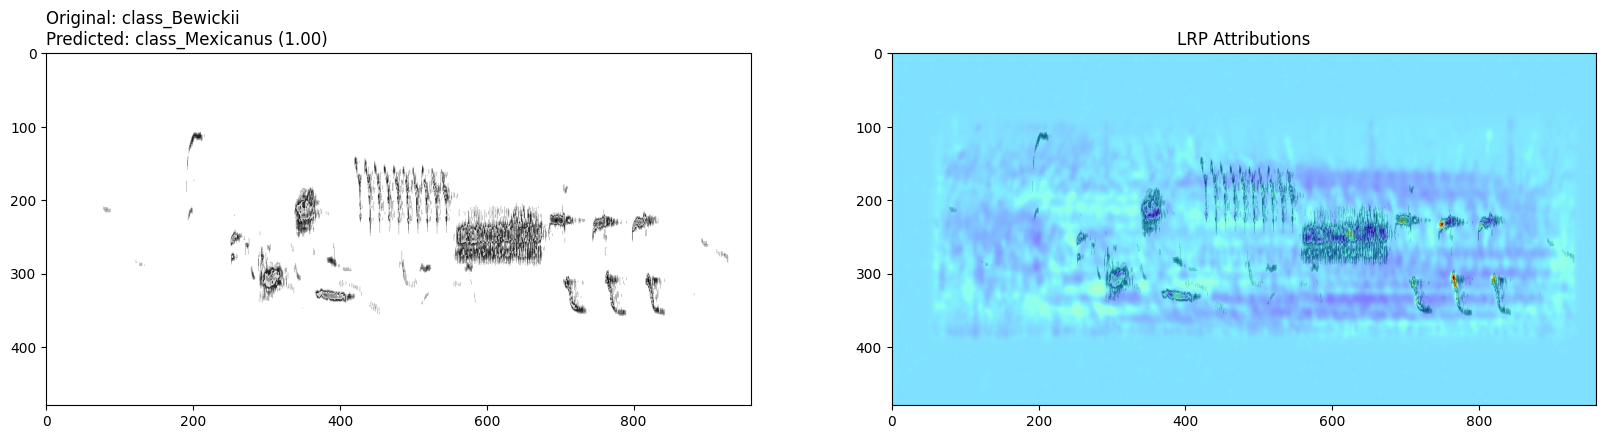

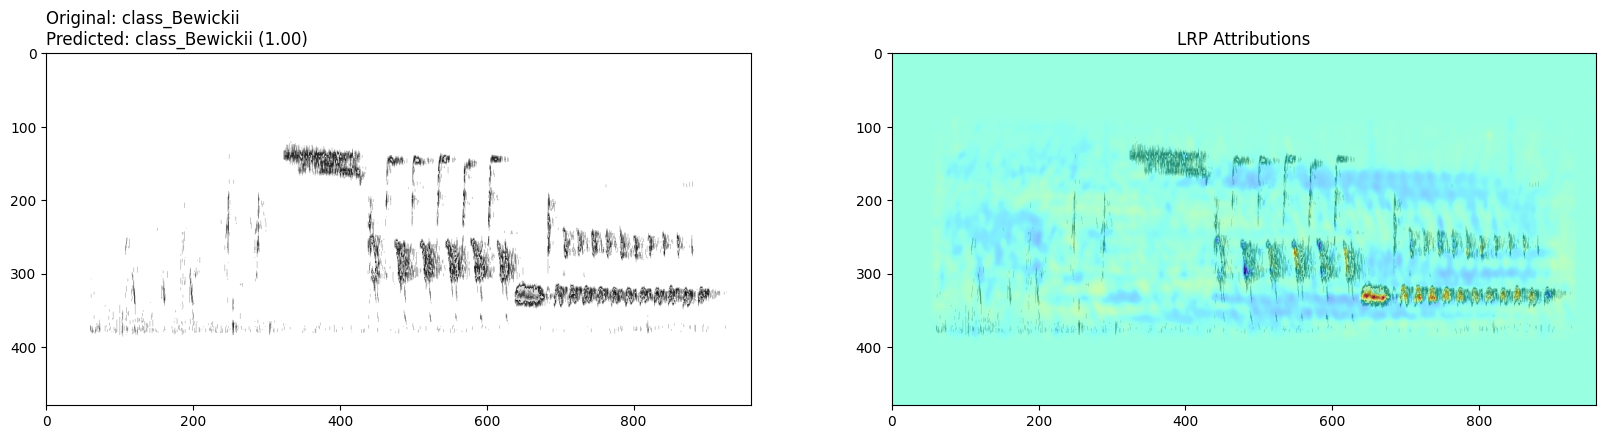

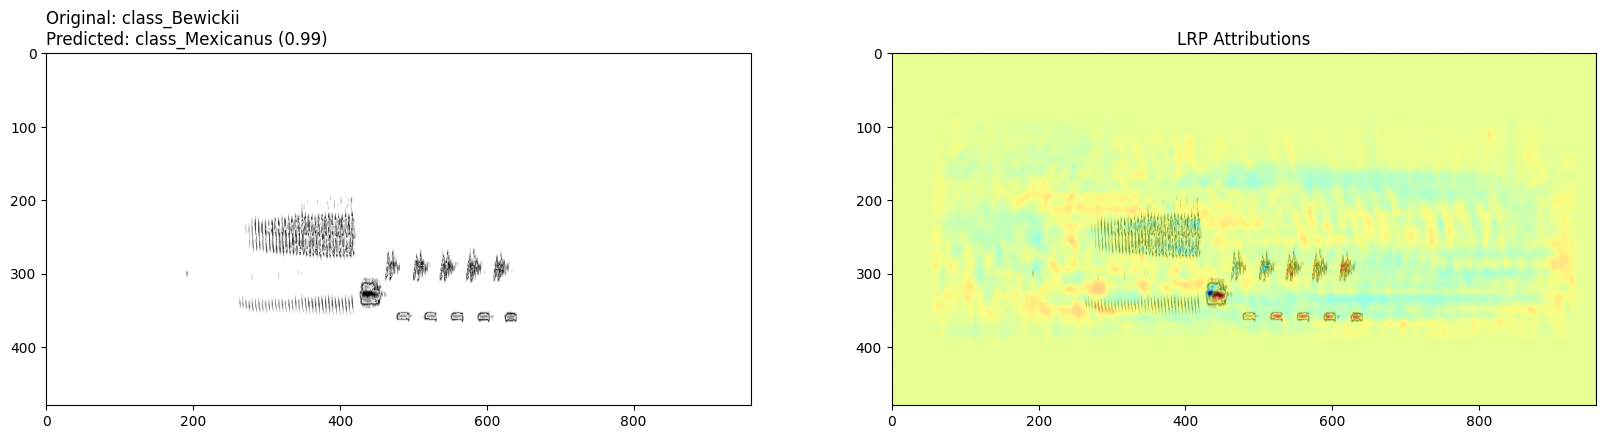

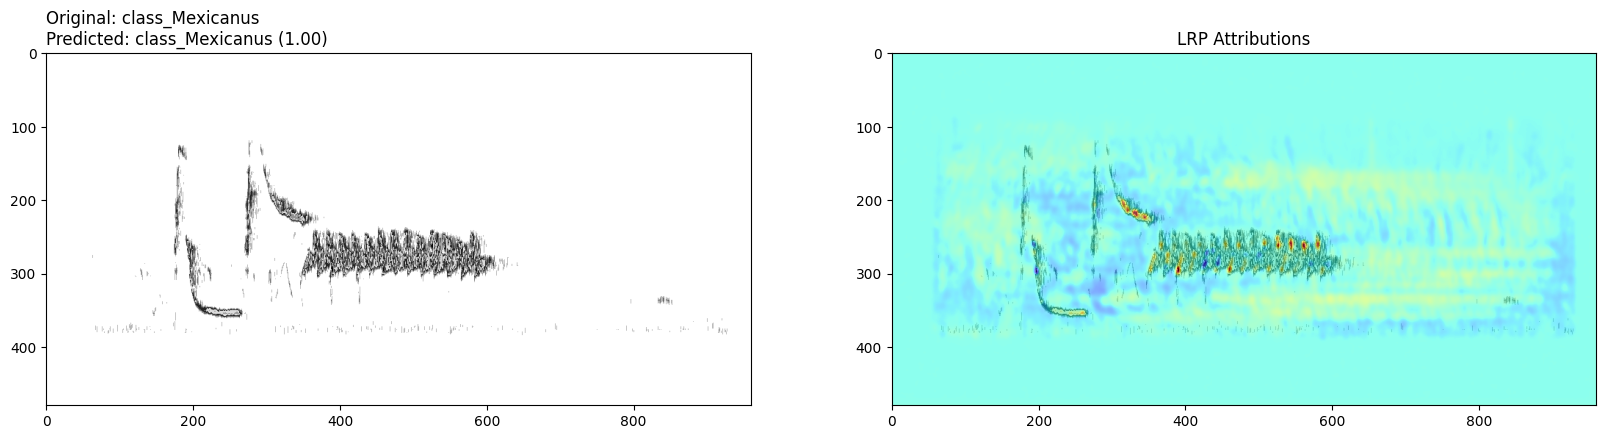

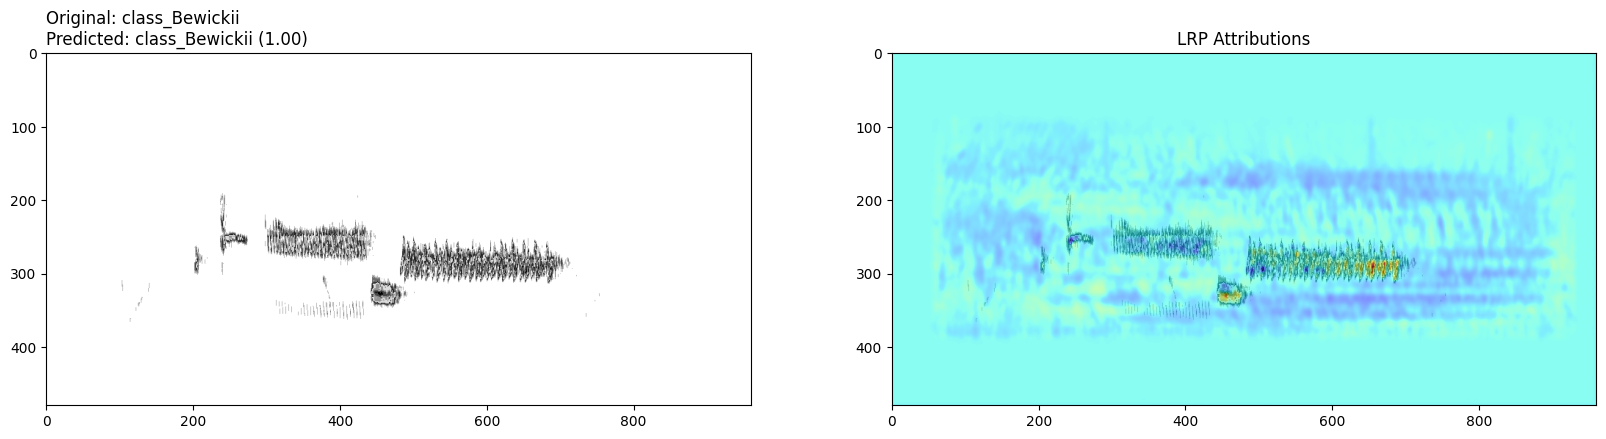

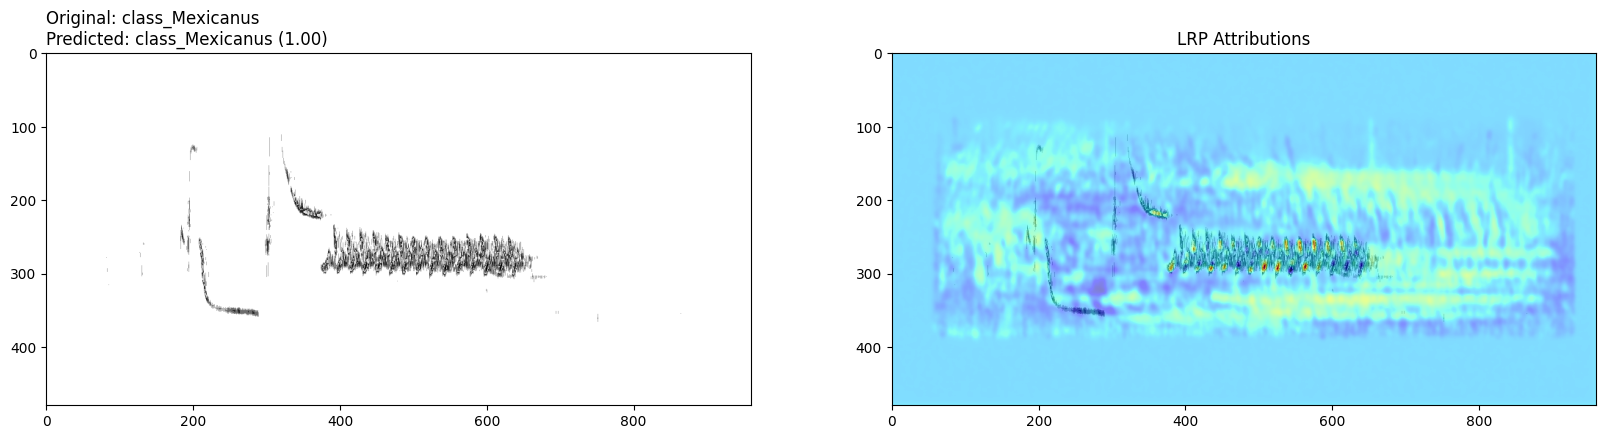

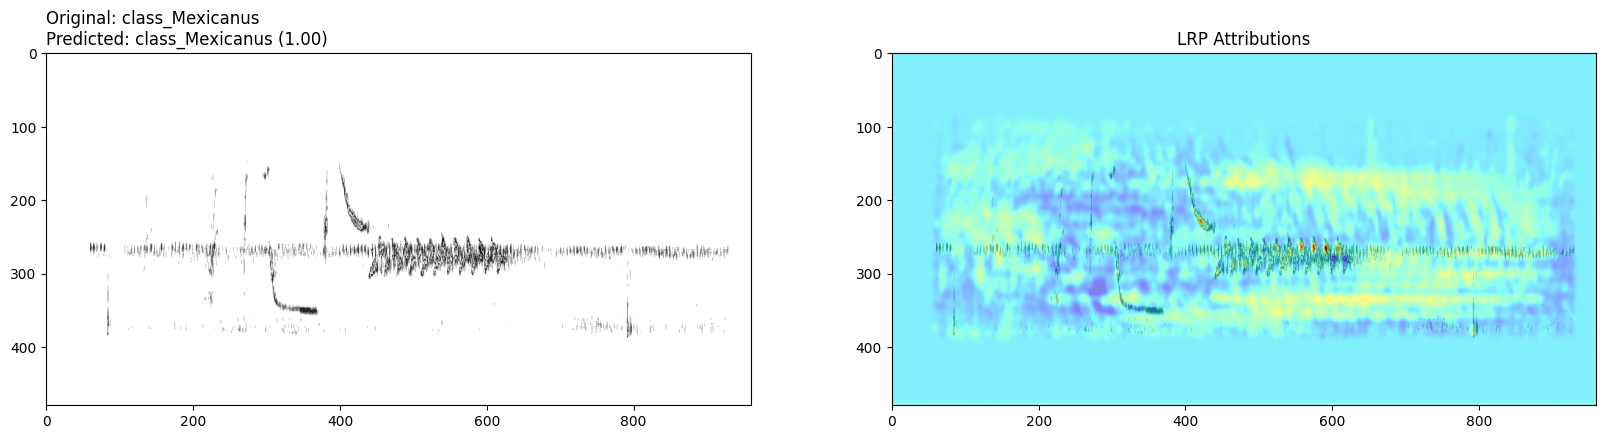

In [8]:
#LRP
model = model.to(device)
model.eval()
# Initialize DeepLift
deeplift = DeepLift(model)

for i in test_image_range:
    image = sample_image[i].unsqueeze(0).to(device)  # Add batch dimension and move to device
    # print(image.size())
    label = sample_label[i]
    
    # Forward pass through the model
    output = model(image)
    # Get the predicted class if not provided
    class_idx = torch.argmax(output, dim=1).item()
    confidence_score = torch.softmax(output, dim=1)[0, class_idx].item()
    # Compute the attributions for a specific target class
    target_class = label

    # Compute attributions using DeepLift
    attributions = deeplift.attribute(image, target=target_class)  #baselines=baseline, 

    # Visualize the attributions
    visualize_lrp(image, attributions, label, class_idx, confidence_score)

Counterfactual

In [9]:
# Define the counterfactual generation function
def generate_counterfactual(model, image, target_class, lr=0.001, max_iter=500, lambda_param=0.01):
    """
    Generate a counterfactual image that changes the model's prediction to the target class.

    Args:
        model: Trained CNN model.
        image: Original input image (1 x C x H x W).
        target_class: Target class index for counterfactual generation.
        lr: Learning rate for gradient descent.
        max_iter: Maximum number of iterations for optimization.
        lambda_param: Weight for the L2 norm regularization term.

    Returns:
        Counterfactual image as a tensor.
    """
    # Make a copy of the input image and enable gradients
    counterfactual = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([counterfactual], lr=lr)

    for iteration in range(max_iter):
        optimizer.zero_grad()

        # Forward pass through the model
        output = model(counterfactual)
        target_loss = -output[0, target_class]  # Maximize the target class score

        # L2 loss to ensure minimal change from the original image
        l2_loss = lambda_param * torch.norm(counterfactual - image)

        # Total loss
        loss = target_loss + l2_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Clamp the counterfactual to valid pixel range [0, 1]
        counterfactual.data = torch.clamp(counterfactual.data, 0, 1)

        # Early stopping if the target class is achieved
        if torch.argmax(model(counterfactual), dim=1).item() == target_class:
            print(f"Counterfactual generated in {iteration + 1} iterations.")
            break
    return counterfactual

def visualize_counterfactual(original, counterfactual):
    """
    Visualize the original and counterfactual images side by side.
    """
    original_img = original.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    counterfactual_img = counterfactual.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original: {class_name[label]}\nPredicted: {class_name[class_idx]} ({confidence_score:.2f})", loc='left')
    plt.imshow(original_img, cmap="gray")

    difference = (original_img - counterfactual_img ) #.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    plt.subplot(1, 2, 2)
    plt.title("Counterfactual Image")
    plt.imshow(difference, cmap="grey")
    # plt.imshow(counterfactual_img, cmap="grey")
    plt.show()
    return

Counterfactual generated in 11 iterations.


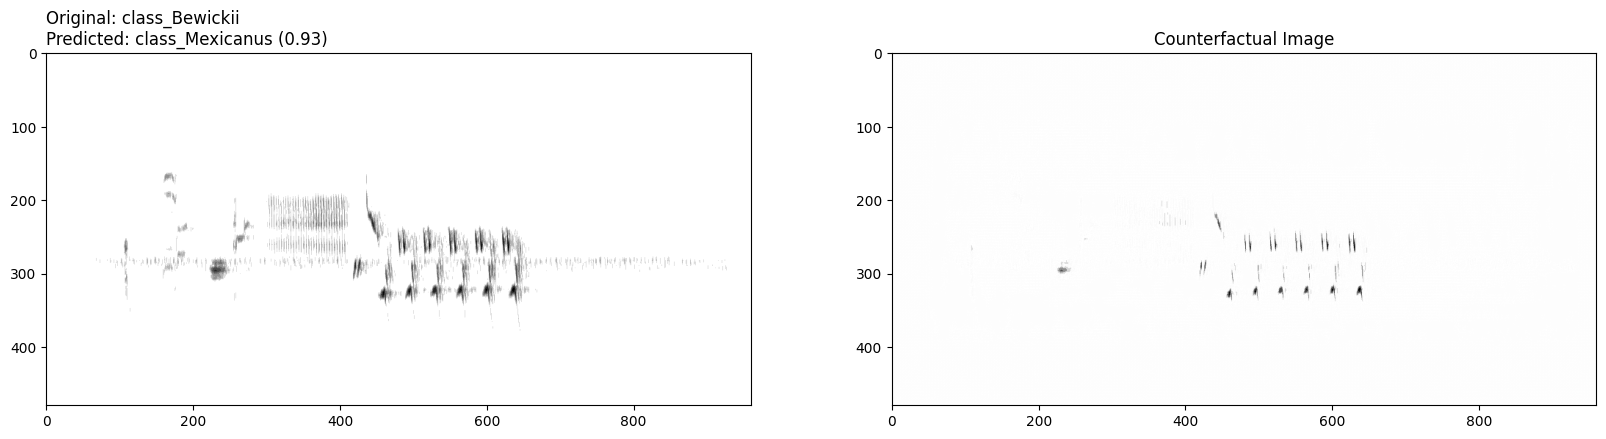

Counterfactual generated in 38 iterations.


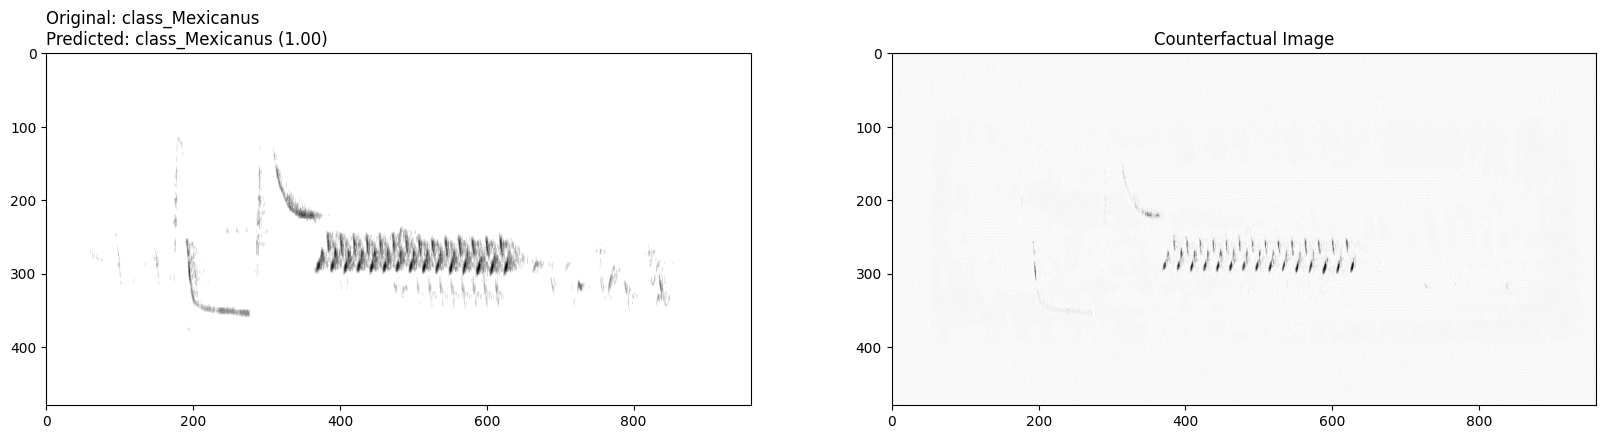

Counterfactual generated in 5 iterations.


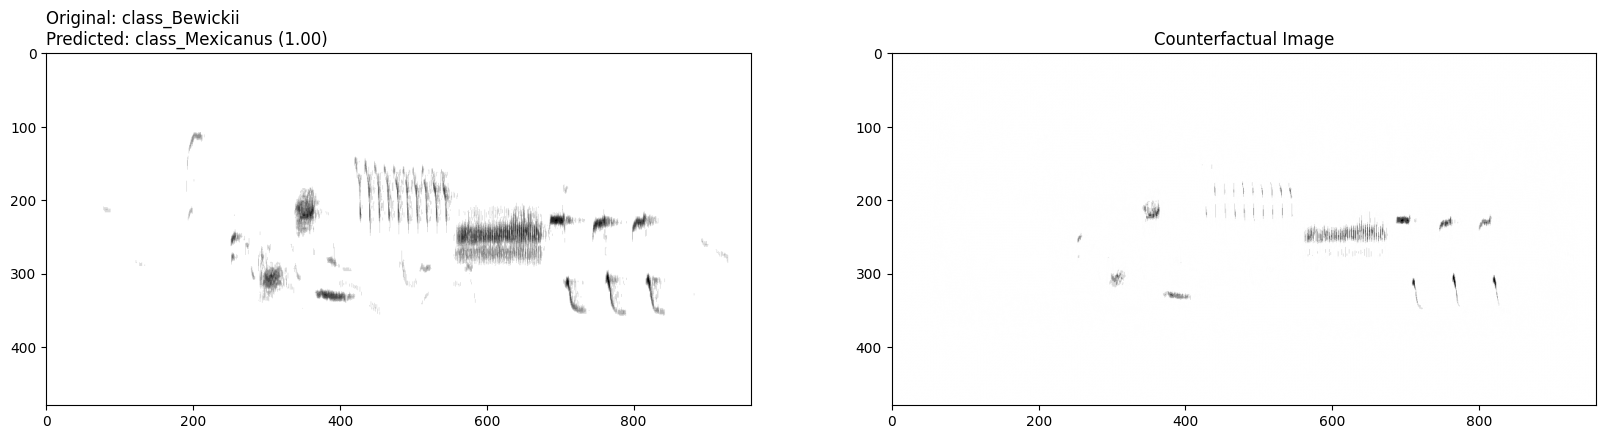

Counterfactual generated in 50 iterations.


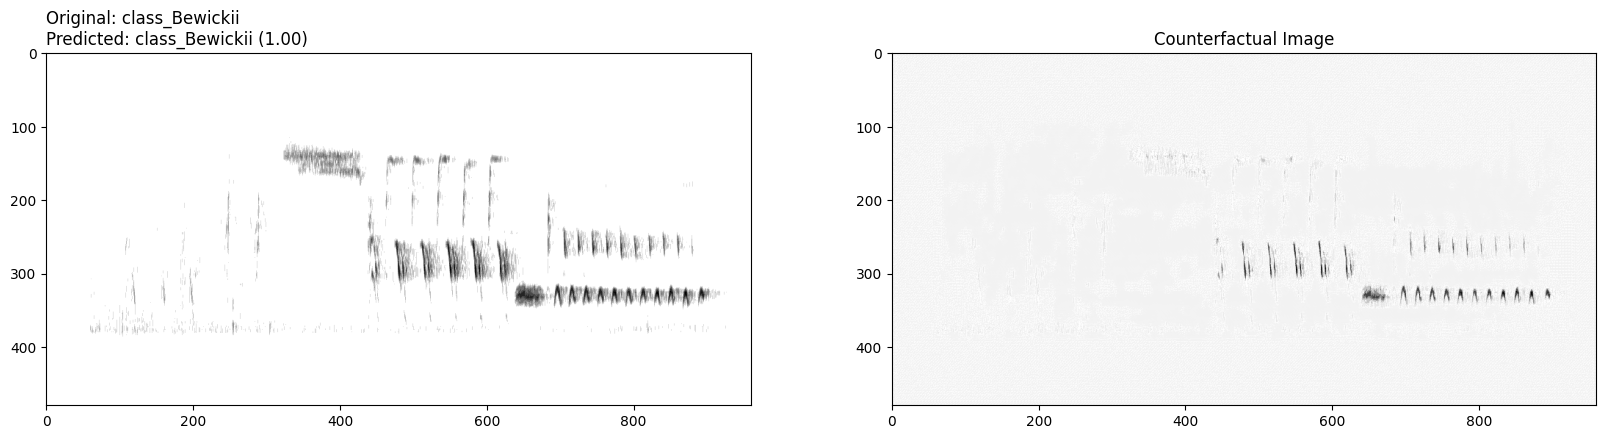

Counterfactual generated in 47 iterations.


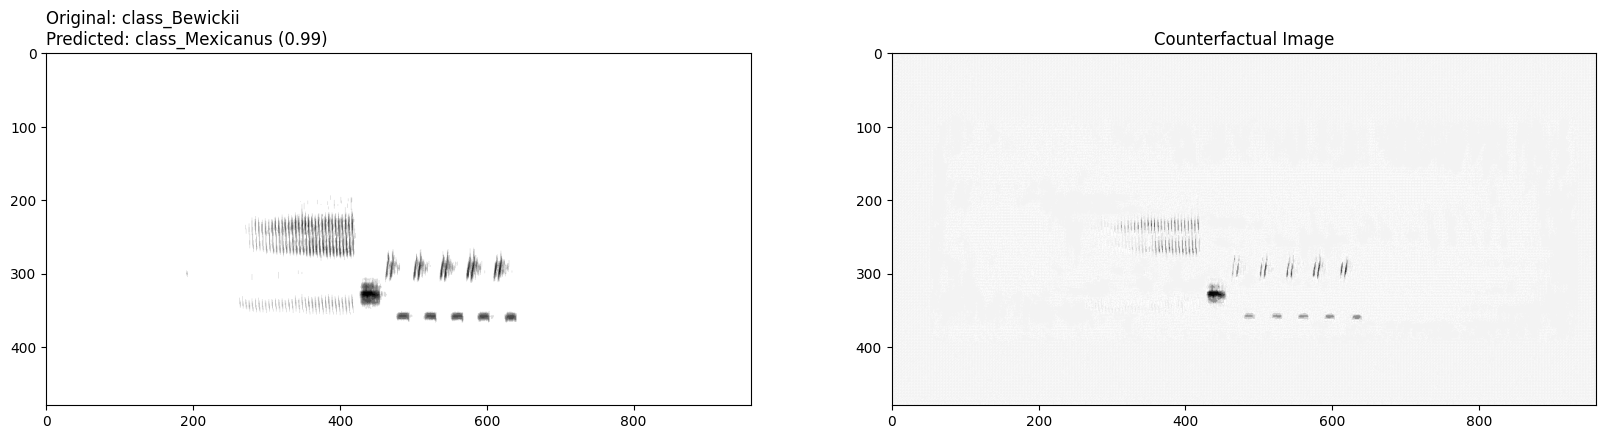

Counterfactual generated in 85 iterations.


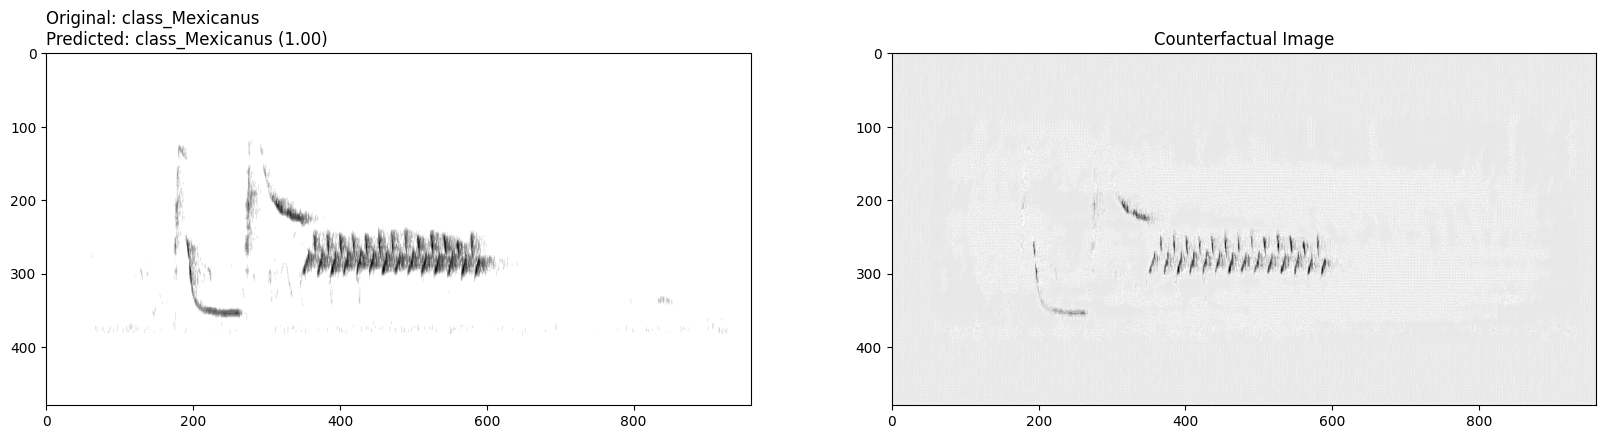

Counterfactual generated in 28 iterations.


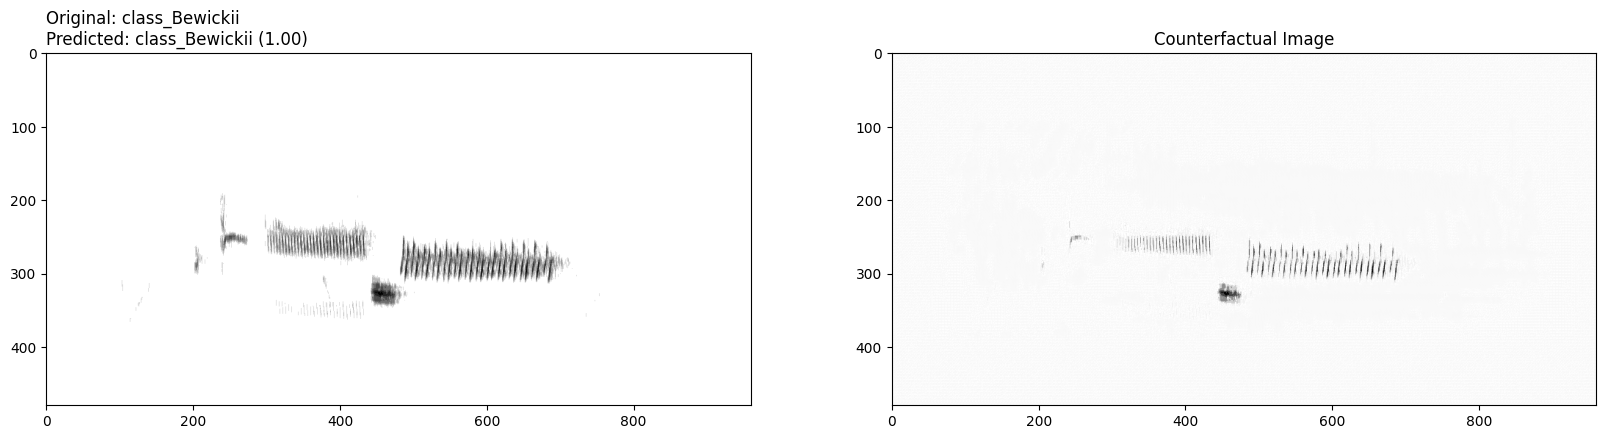

Counterfactual generated in 52 iterations.


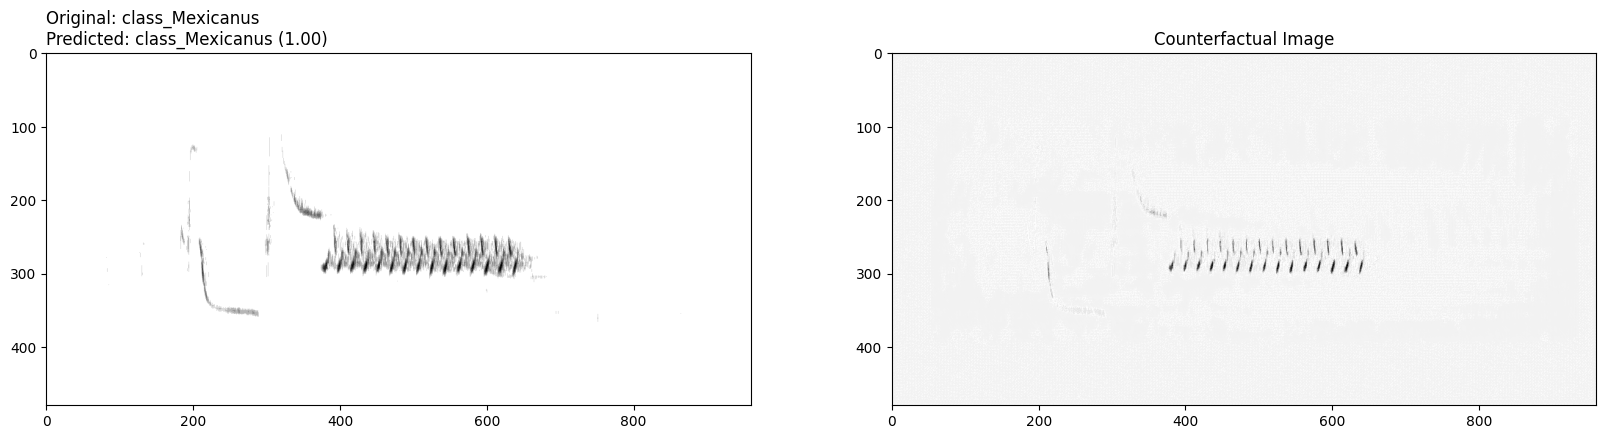

Counterfactual generated in 34 iterations.


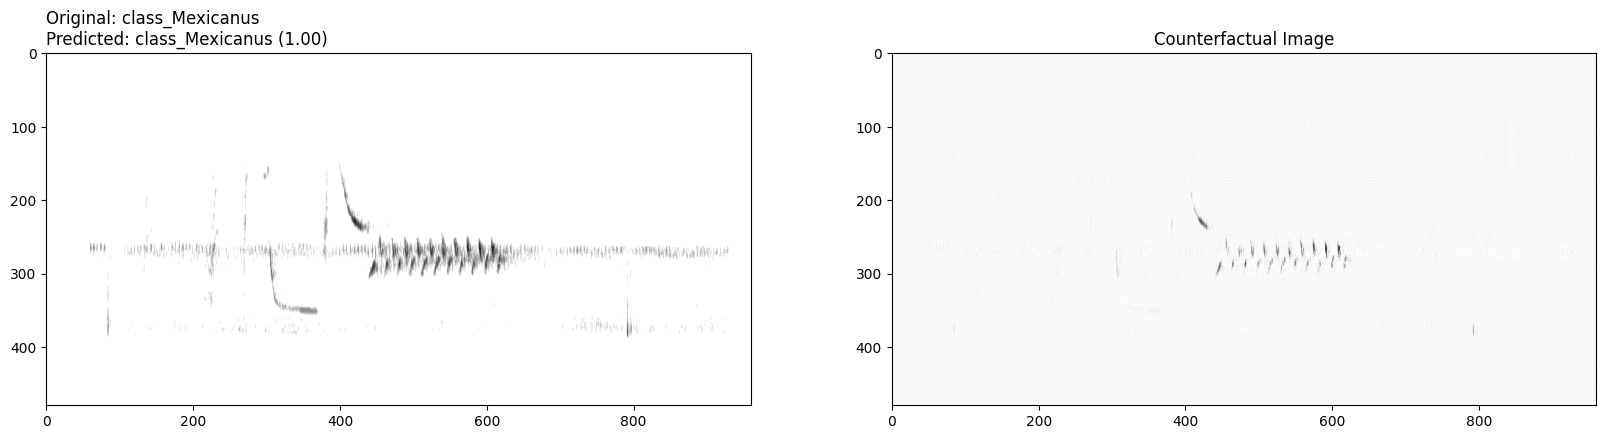

In [10]:
for i in test_image_range:
    image = sample_image[i].unsqueeze(0).to(device)  # Add batch dimension and move to device
    # print(image.size())
    label = sample_label[i]
    
    # Forward pass through the model
    output = model(image)
    
    # Get the predicted class if not provided
    class_idx = torch.argmax(output, dim=1).item()
    confidence_score = torch.softmax(output, dim=1)[0, class_idx].item()

    # Compute the attributions for a specific target class
    target_class = 1 - class_idx
    counterfactual_image = generate_counterfactual(model, image, target_class)
    visualize_counterfactual(image, counterfactual_image)